The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


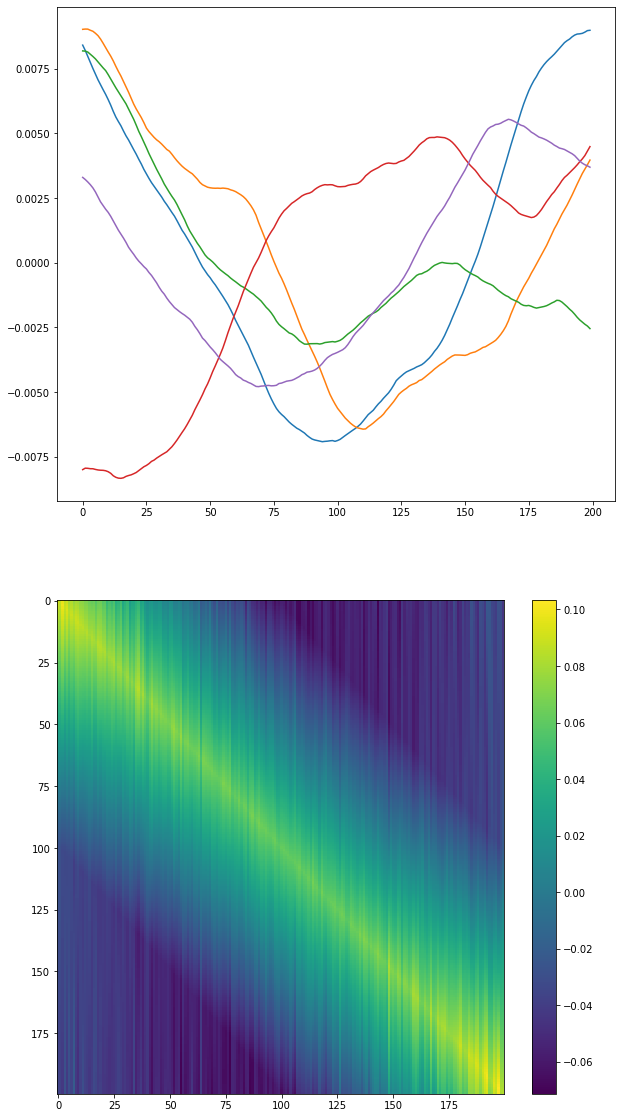

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import spe
import numpy as np
import matplotlib.pyplot as plt
from torch.fft import rfft, irfft

# create the positional encoder, with a resolution (max lag) of 500
device = 'cuda' if torch.cuda.is_available() else 'cpu'
key_dim = 1

encoder = spe.SpectralSPE(dimension=key_dim, max_lag=100).to(device)

m = 200
n = 200

q = torch.ones(1, m, key_dim, device=device)
k = torch.ones(1, n, key_dim, device=device)

# generate some encodings of length
# (batchsize, m/n, num)
qhat, khat = encoder(q,k,num=20000)

# display the first 20 of them
qhat = qhat.detach()
khat = khat.detach()
plt.figure(figsize=[10,20])
plt.subplot(211)
plt.plot(qhat[0,:,:5].cpu())

#plt.plot(qhat[0, 100, :].cpu(), 'r.')
#plt.xlabel('q')
#plt.ylabel('k')

# compute the p.T p to display the corresponding attention matrix
plt.subplot(212)
C = torch.mm(qhat[0], khat[0].T)
#C = torch.relu(C)
plt.imshow(C.detach().cpu().numpy(), aspect='auto', interpolation='nearest')
plt.colorbar()

torch.Size([100, 100])
torch.Size([1, 100, 500])


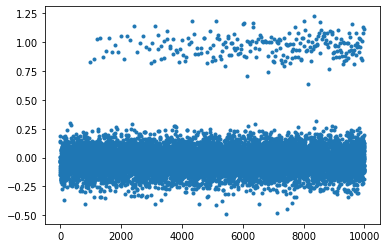

In [11]:
print(C.shape)
print(qhat.shape)
plt.plot(C.view(-1), '.')

tensor([ 2.0000+0.j, -0.6180+0.j, -1.6180+0.j,  1.6180+0.j,  0.6180+0.j, -2.0000+-0.j,
         0.6180+0.j,  1.6180+0.j, -1.6180+0.j, -0.6180+0.j,  2.0000+0.j],
       grad_fn=<ViewAsComplexBackward>)

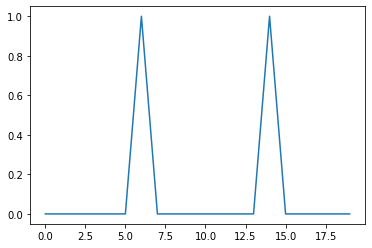

In [2]:
plt.plot(encoder.kernel[0].detach())
torch.fft.rfft(encoder.kernel[0])

In [4]:
from torch.nn.functional import pad
v = torch.ones(5)
print(v)

tensor([1., 1., 1., 1., 1.])


In [4]:
v = torch.linspace(1,10,10)
v[1::2]

tensor([ 2.,  4.,  6.,  8., 10.])

In [193]:
n= 100
r=50


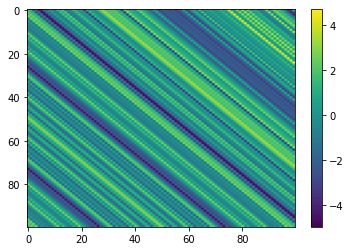

In [248]:
v = torch.randn(r, dtype=torch.cfloat); v=v/v.abs()
Vq = v[None, :] ** torch.linspace(0,1000,n)[:, None]
Vk = v[None, :] ** torch.linspace(500,1500,n)[:, None]
lamb = torch.rand(r)
Q = Vq*lamb[None]
K = Vk*lamb[None]
#plt.imshow((AA).detach().cpu().numpy(), aspect='auto')
plt.imshow(torch.mm(Q, torch.conj(K.T)).real.detach().cpu().numpy(), aspect='auto')
plt.colorbar()

In [246]:
Q.shape

torch.Size([100, 50])

tensor([0.0560, 0.0552, 0.0531, 0.0501, 0.0466, 0.0431, 0.0399, 0.0371, 0.0349,
        0.0332, 0.0320, 0.0312, 0.0310, 0.0312, 0.0320, 0.0332, 0.0349, 0.0371,
        0.0399, 0.0431, 0.0466, 0.0501, 0.0531, 0.0552])
tensor([0.0560, 0.0552, 0.0531, 0.0501, 0.0466])
tensor([0.0431, 0.0466, 0.0501, 0.0531, 0.0552])
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]) tensor([20, 19, 18, 17, 16, 15, 14, 13, 12]) torch.Size([24])
tensor([0.0552, 0.0531, 0.0501, 0.0466, 0.0431, 0.0399, 0.0371, 0.0349, 0.0332,
        0.0320])
tensor([0.0466, 0.0431, 0.0399, 0.0371, 0.0349, 0.0332, 0.0320, 0.0312, 0.0310])
torch.Size([198])


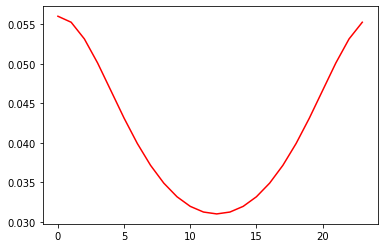

In [11]:

v = torch.logspace(0, -10, 13)
#plt.plot(v,'k')
vv = irfft(v)
plt.plot(vv,'r')
print(vv)
print(vv[:5])
print(vv[-5:])
print(encoder.pos, encoder.neg, vv.shape)
print(vv[encoder.pos])
print(vv[encoder.neg])

n = 100
print(irfft(torch.rand(n)).shape)

In [3]:
print(encoder.kernel[0].shape)

torch.Size([21])


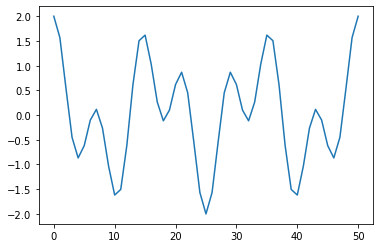

In [9]:
plt.plot(rfft(encoder.kernel[0]).detach().real)

In [3]:
print(encoder.pos)
print(encoder.neg)

tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
tensor([20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,
         2,  1])


In [3]:
encoder.pos[5]

tensor(6)